### Dataset: Energy Efficiency with HL (heating load) as target

In [1]:
from ucimlrepo import fetch_ucirepo

energy_efficiency = fetch_ucirepo(id=242) 
  
X = energy_efficiency.data.features 
y = energy_efficiency.data.targets

var_df = energy_efficiency.variables
col_map = dict(zip(var_df["name"], var_df["description"]))
X = X.rename(columns=col_map)
y = y.rename(columns=col_map)

y = y[["Heating Load"]]
df = X.join(y)
df.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84


### Train test split

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,     
    random_state=42,   
    shuffle=True
)

print(f"#X_train = {len(X_train)}   #y_train = {len(y_train)}")
print(f"#X_test = {len(X_test)}     #y_test = {len(y_test)}")

#X_train = 691   #y_train = 691
#X_test = 77     #y_test = 77


### EDF normalization

In [3]:
from src.edf import edf_normalize, col_denorm

X_train_norm, X_test_norm, _ = edf_normalize(X_train, X_test)
y_train_norm, y_test_norm, edf_models = edf_normalize(y_train, y_test)

y_denorm = col_denorm("Heating Load", edf_models)

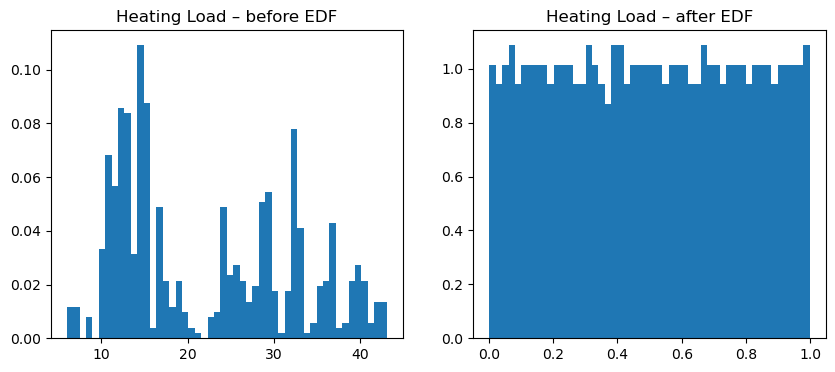

In [4]:
from src.edf import plot_hists

col = "Heating Load"
plot_hists(y_train[col], y_train_norm[col], name=col)

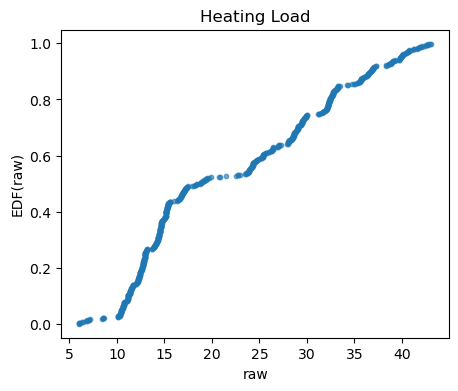

In [5]:
from src.edf import plot_raw_vs_norm

col = "Heating Load"
plot_raw_vs_norm(y_train[col], y_train_norm[col], name=col)

### Rescaled Legendre polynomials

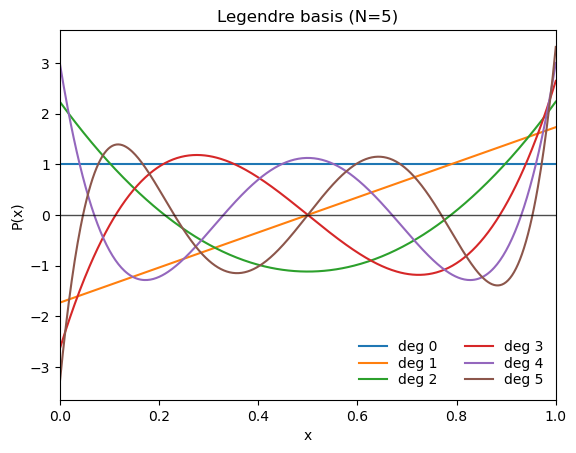

In [6]:
from src.legendre import RescaledLegendre, plot_rescaled_legendre

N = 5
poly_basis = []

for n in range(N+1):
    poly_basis.append(RescaledLegendre(n))

plot_rescaled_legendre(poly_basis, title = f"Legendre basis (N={N})")

### Prepare features for HCR

In [7]:
from src.features import moment_like_features, target_features

N = 4
V_train = moment_like_features(X_train_norm, N)
V_test  = moment_like_features(X_test_norm, N)

targets_train = []
targets_test  = []

for n in range(1, N+1):
    targets_train.append(target_features(y_train_norm, n))
    targets_test.append(target_features(y_test_norm, n))

### L1 regression

In [8]:
from src.hcr import fit_lasso

models = []
for n in range(N):
    models.append(fit_lasso(V_train, targets_train[n]))

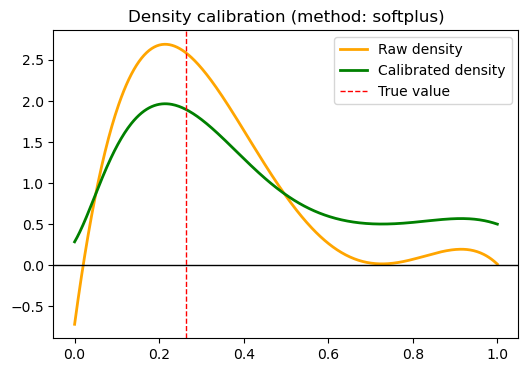

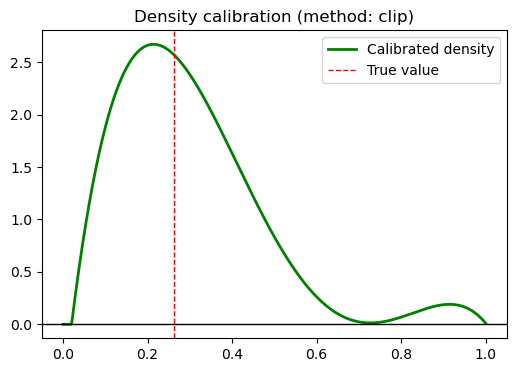

In [9]:
from src.hcr import make_density, plot_density

id = 1
v = V_test.iloc[[id]]
y_true = y_test_norm.iloc[[id]].iloc[0, 0]
density = make_density(models, v)
plot_density(density, y_true, raw=True)
plot_density(density, y_true, method="clip")

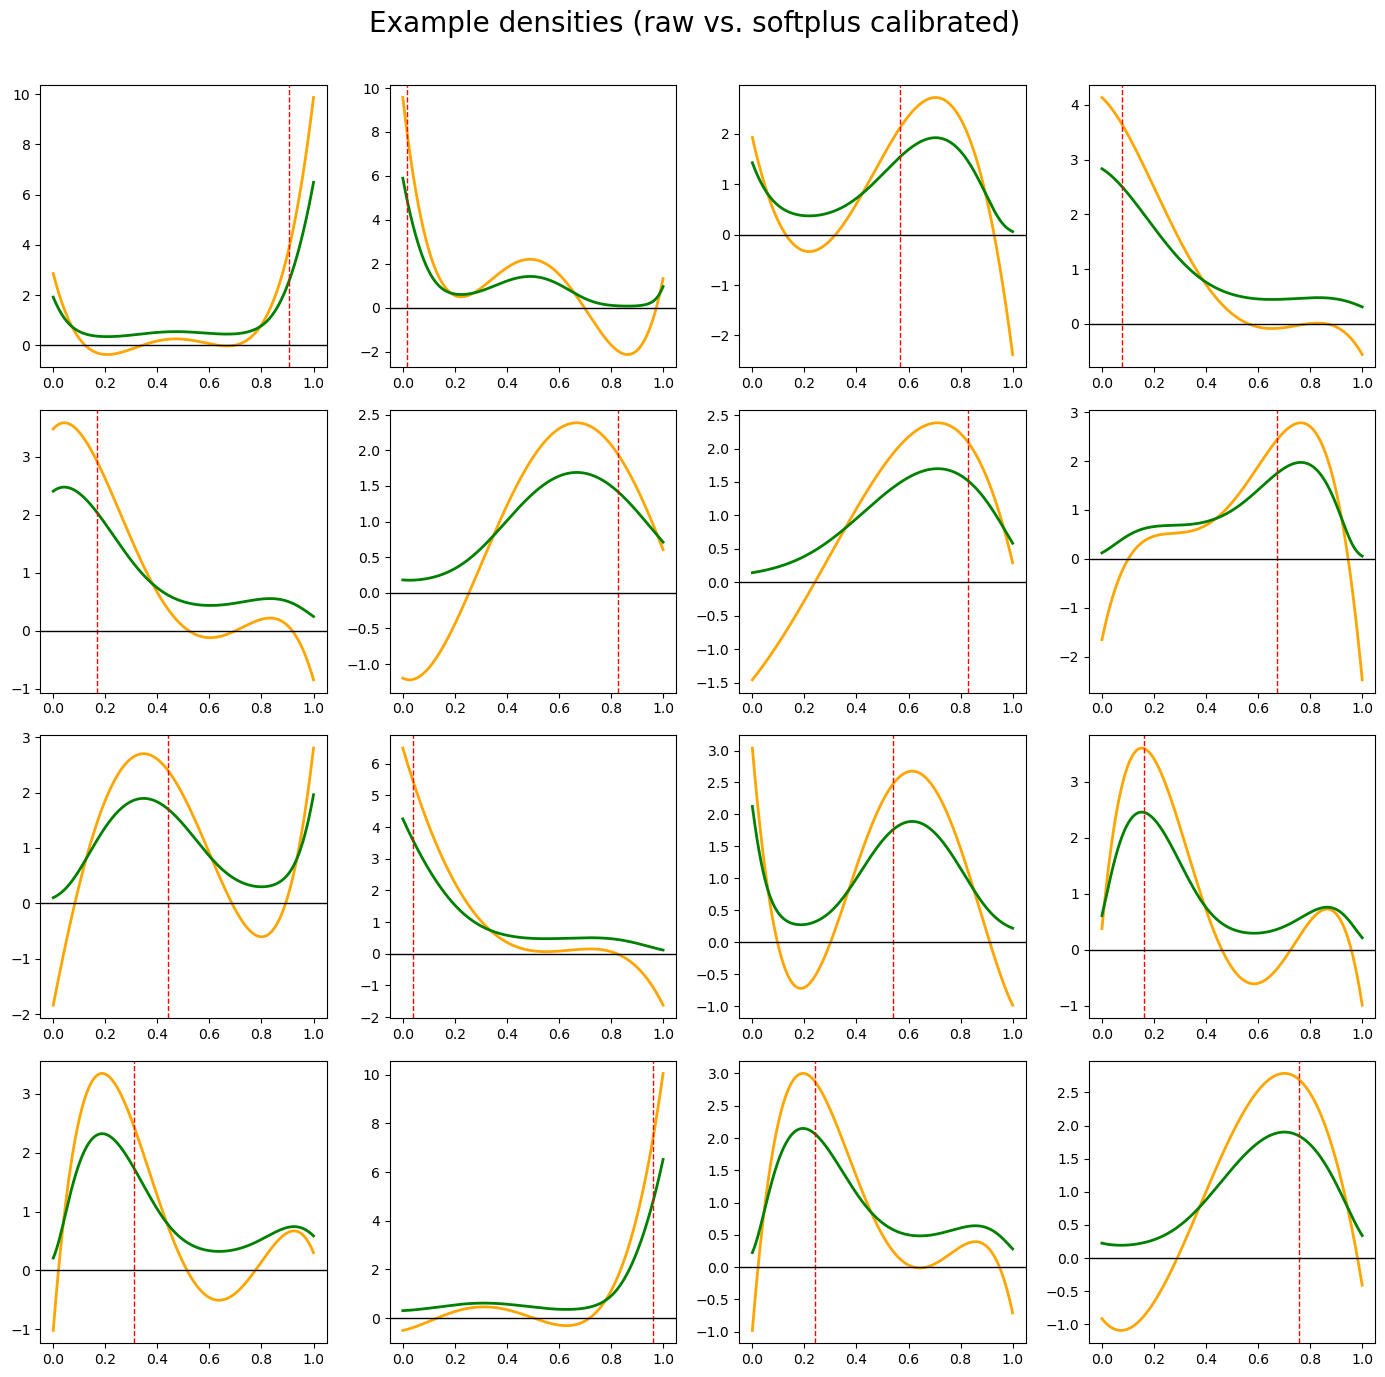

In [10]:
from src.hcr import plot_example_densities

plot_example_densities(V_test, y_test_norm, 
                       models, name="Example densities (raw vs. softplus calibrated)",
                       seed=33, raw=True)

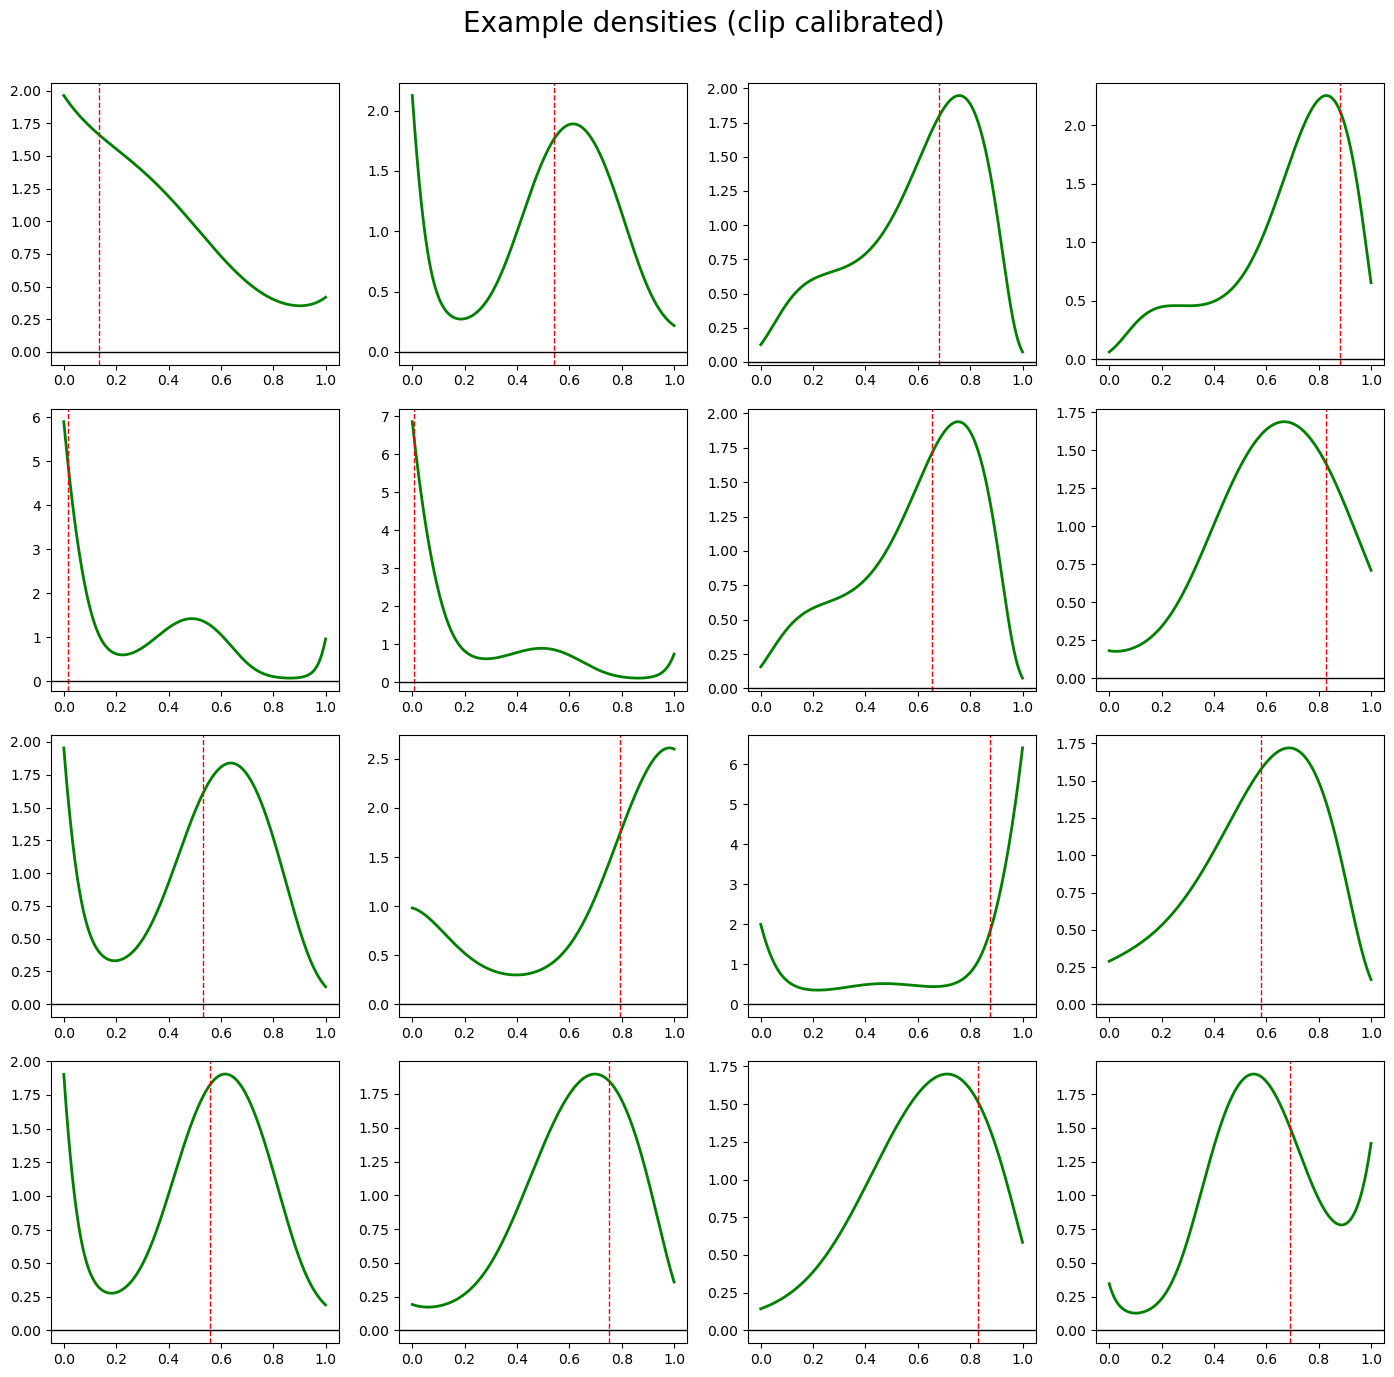

In [11]:
plot_example_densities(V_test, y_test_norm, 
                       models, name="Example densities (clip calibrated)",
                       seed=16)

### Log-likelihood evaluation

In [12]:
from src.evaluation import mean_log_likelihood

ll_softplus = mean_log_likelihood(V_test, y_test_norm, models)
ll_clip = mean_log_likelihood(V_test, y_test_norm, models, calibration_method="clip")

print(f"Mean log-likelihood (softplus): {ll_softplus:.4f}")
print(f"Mean log-likelihood (clip): {ll_clip:.4f}")

Mean log-likelihood (softplus): 0.7688
Mean log-likelihood (clip): 1.0098


### Expected value prediction and MSE evaluation

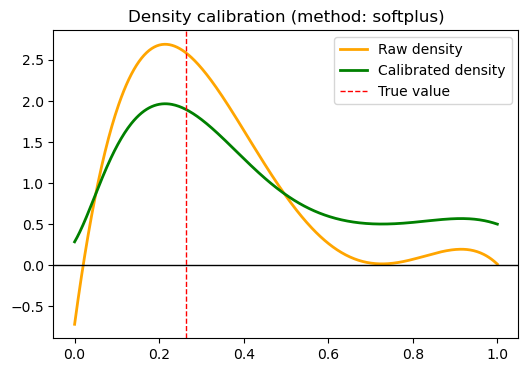

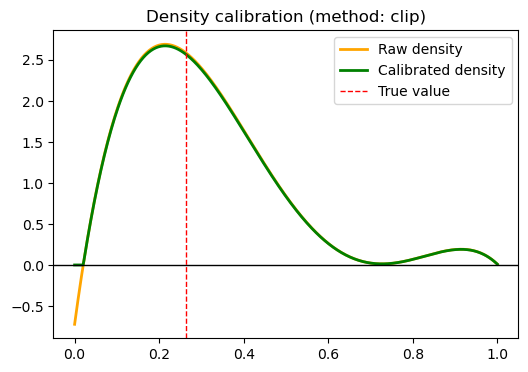

True value: 13.17
True value (normalized): 0.2634
Predicted value (softplus clibration): 0.3908
Predicted value (clip clibration): 0.2941
Denormalized predicted value (softplus clibration): 15.1600
Denormalized predicted value (clip clibration): 14.1997


In [13]:
from src.evaluation import expected_value
from src.hcr import make_density, calibrate_density

id = 1
v = V_test.iloc[[id]]
y_true = y_test.iloc[[id]].iloc[0, 0]
y_norm = y_test_norm.iloc[[id]].iloc[0, 0]


density = make_density(models, v)
density_softplus = calibrate_density(density)
density_clip = calibrate_density(density, method="clip")

plot_density(density, y_norm, raw=True)
plot_density(density, y_norm, method="clip", raw=True)

y_pred_softplus = expected_value(density_softplus)
y_pred_clip = expected_value(density_clip)

y_pred_softplus_denorm = y_denorm(y_pred_softplus)
y_pred_clip_denorm = y_denorm(y_pred_clip)

print(f"True value: {y_true}")
print(f"True value (normalized): {y_norm:.4f}")
print(f"Predicted value (softplus clibration): {y_pred_softplus:.4f}")
print(f"Predicted value (clip clibration): {y_pred_clip:.4f}")
print(f"Denormalized predicted value (softplus clibration): {y_pred_softplus_denorm:.4f}")
print(f"Denormalized predicted value (clip clibration): {y_pred_clip_denorm:.4f}")

In [14]:
from src.evaluation import mse_evaluation

mse_softplus = mse_evaluation(V_test, y_test, models, y_denorm)
mse_clip = mse_evaluation(V_test, y_test, models, y_denorm, calibration_method="clip")

print(f"HL test MSE (softplus clibration): {mse_softplus:.4f}")
print(f"HL test MSE (clip clibration): {mse_clip:.4f}")

HL test MSE (softplus clibration): 23.1075
HL test MSE (clip clibration): 8.0609


### Model weights

In [93]:
from src.weights import print_coeffs

target_deg = 1
print(f"Coefficients for modeling deg={target_deg} target:\n")
print_coeffs(models[target_deg-1], V_train)

Coefficients for modeling deg=1 target:

Degree 1:
  Roof Area: 0.7919
  Wall Area: 0.5660
  Glazing Area: 0.3108
  Glazing Area Distribution: 0.0211
  Orientation: -0.0094
  Relative Compactness: 0.0000
  Surface Area: -0.0000
  Overall Height: 0.0000

Degree 2:
  Roof Area: -1.1105
  Relative Compactness: 0.5915
  Wall Area: 0.5307
  Glazing Area Distribution: -0.0388
  Glazing Area: -0.0039
  Surface Area: 0.0000
  Overall Height: -0.0000
  Orientation: -0.0000

Degree 3:
  Wall Area: 0.0888
  Glazing Area Distribution: 0.0396
  Roof Area: 0.0346
  Glazing Area: 0.0067
  Orientation: 0.0002
  Relative Compactness: 0.0000
  Surface Area: 0.0000
  Overall Height: 0.0000

Degree 4:
  Relative Compactness: 0.7365
  Surface Area: -0.6364
  Roof Area: 0.0642
  Wall Area: -0.0387
  Glazing Area Distribution: -0.0228
  Orientation: 0.0059
  Overall Height: 0.0000
  Glazing Area: 0.0000



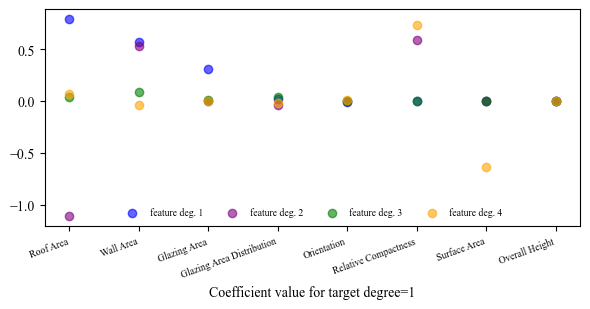

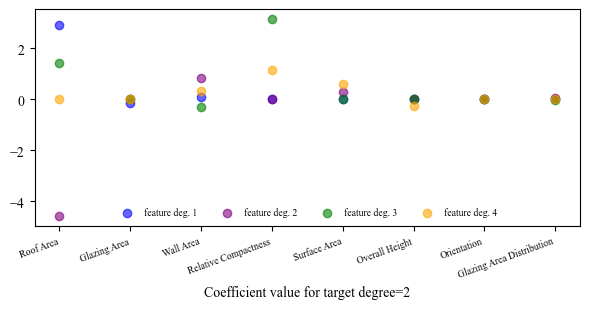

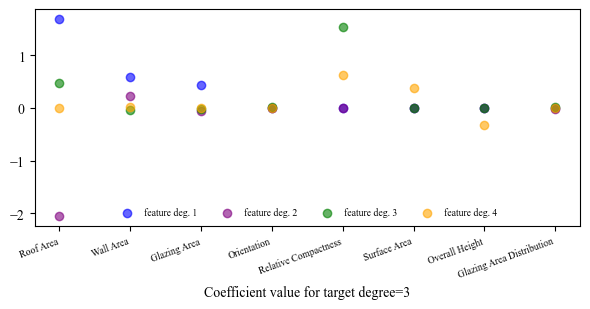

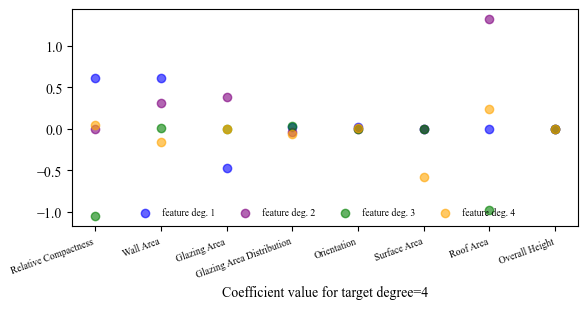

In [110]:
from src.weights import plot_coeffs

colors = ["blue", "purple", "green", "orange"]
for deg in range(1, N+1):
    plot_coeffs(models[deg-1], V_train, target_deg=deg, colors=colors)